# TP 1 - Grupo 7

André Filipe Dourado Pinheiro - A108473

Tiago Silva Costa - A108657

# Problema 1 - Vehicle routing problem


1. Para um distribuidor de encomendas o seu território está organizados em pontos (“nodes”) de fornecimento (“sources”), pontos de passagem  e pontos de entrega (“sinks”) ligados por vias de comunicação (“edges”) bidirecionais cada uma das quais associada uma capacidade em termos do número de veículos de transporte que suporta.
2. Os items distribuidos estão organizados em “pacotes” de três tipos “standard” : uma unidade, duas unidades e cinco unidades. Os pacotes são transportados em veículos todos com a capacidade de 10 unidades. Cada ponto de entrega tem um limite no número total de unidades que tem em “stock” e um limite no número de veículos que dispõe.
3. Cada encomenda é definida por o identificador do ponto de entrega e pelo número de pacotes, de cada um dos tipos, que devem ser entregues nesse ponto.
4. O objetivo do problema é decidir, a partir de uma encomenda e com um mínimo no número de veículos,
    - em cada ponto de entrega,  se estará envolvido no fornecimento de unidades que essa encomenda requer sem violar os limites do seu “stock”.
    - em cada ponto de entrega,   como empacotar as unidades disponíveis, de acordo com a encomenda”,  e como as distribuir por veículos,
    - em cada veículo, qual o percurso a seguir até  ao ponto de entrega; para cada via ao longo de cada percurso, o total de veículos não pode exceder a capacidade dessa via.

## Modelação

Para resolver o problema, faremos uso da biblioteca de programação linear do **OR-Tools**, o **pywraplp**. Assim, começamos por importar a biblioteca e criar uma instância do `solver`, a que daremos o nome de *solver*. Além disso, usaremos a biblioteca **NetworkX** para representar e manipular grafos.

In [2]:
import networkx as nx
from ortools.linear_solver import pywraplp
import matplotlib.cm as cm
import random
solver = pywraplp.Solver.CreateSolver('SCIP')

### Variáveis
Começemos por inicializar aos *inputs* do nosso problema arbitráriamente a título de exemplo. Portanto, sejam:

 1. $n \in \mathbb{N}$ o número de vertíces do grafo.
 2. $\{ R,F,P \}$ uma partição de $\{0,\cdots,n-1\}$, em que $R$ é conjunto dos pontos de recolha, $F$ o conjunto dos pontos de fornecimento e $P$ o conjunto dos pontos de paragem.
 3. $h \in \mathbb{N_0}^{n \times n}$ a matriz de adjacência do grafo, em que 
 
 $$h_{i,j} = 
 \begin{cases} 
 \text{capacidade da estrada entre } i \text{ e } j, & \text{se existir estrada} \\
  0, & \text{caso contrário} 
 \end{cases} 
 $$ 

 (Nota: tem-se que $h_{i,i}=0$ para todo $i < n$)

 4. $s \in \mathbb{N_0}^{n}$ um vetor, em que $s_i$ representa o limite de unidades do ponto de fornecimento $i$.
 5. $v \in \mathbb{N_0}^n$ um vetor, em que $v_i$ representa o limite de veículos que o ponto de fornecimento $i$ dispõe.
 6. $a \in \mathbb{N_0}^3$ um vetor, em que $a_i$ representa o número de pacotes do tipo $t$ que a encomenda possui. 
 7. $sink$ o identificador do ponto de entrega.

Reparemos que será usado no máximo $a_0+a_1+a_2$ veículos, pois no pior caso cada veículo leva um pacote.
Para simplificar na notação, vamos definir:

1. $V = \{0,\cdots,n-1\}$
2. $K = \{0,\cdots,a_0+a_1+a_2-1\}$


In [3]:
# Inputs
n = 15
a = {0:5,1:4,2:2}
sink = 12
R, F = {12,13,2}, {14,10,1,3}

# Construção da matriz de adjacência
V = range(n)
K = range(a[0]+a[1]+a[2])

h = {(i,j): 0 for i in V for j in V}
for i in V:
    for j in V:
        if i<j:
            if random.random() < 0.3:
                h[i,j] = random.randint(1, 3)
                h[j,i] = h[i,j]

s = { i: random.randint(1, 30) for i in F }
v = { i: random.randint(1, 10) for i in F }

Vamos definir as variáveis de decisão essenciais para modelar o problema. Sejam:

 1. **Variáveis de rota dos veículos** 
 $$x_{i,j,k} \in \{0,1\}, \quad \forall i,j \in V, \; \forall k \in K,$$
 em que 
 $$
 x_{i,j,k} =
\begin{cases} 
1, & \text{se o veículo } k \text{ utiliza a aresta } (i,j) \text{ no seu percurso}, \\[2mm]
0, & \text{caso contrário}.
\end{cases}$$
 
 2. **Variáveis de transporte de pacotes** 
$$t_{i,j,k} \in \{0,1,\cdots,10\}, \quad \forall i \in F, \; \forall j \in K, \; \forall k \in \{0,1,2\},$$
em que 
$$t_{i,j,k} = \text{número de pacotes do tipo } k \text{ transportados pelo veículo } j \text{ a partir do ponto de fornecimento } i.$$
 
 3. **Variáveis de saída dos veículos**  
 $$r_{i,j} \in \{0,1\}, \quad \forall i \in F, \; \forall j \in K,$$
 em que 
 $$
 r_{i,j} =
\begin{cases} 
1, & \text{se o veículo } j \text{ parte do ponto de fornecimento } i, \\[1mm]
0, & \text{caso contrário}.
\end{cases}
 $$
 

In [4]:
# Variáveis de decisão
x,t,r = {},{},{}
for i in V:
    for j in V:
        for k in K:
            x[i,j,k] = solver.BoolVar('x[%i][%i][%i]' % (i,j,k))

    for j in K:
        r[i,j] = solver.BoolVar('r[%i][%i]' % (i,j))
        for k in range(3):
            t[i,j,k] = solver.IntVar(0.0,10.0,'t[%i][%i][%i]' % (i,j,k))


### Restrições

Formalizamos a restrições do problema

1. A capacidade dos veículos é respeitada, isto é, o número de unidades que cada veículo transporta não pode ser superior a 10.
$$ \forall j \in K, \forall i \in F, \quad t_{i,j,0}\cdot 1 + t_{i,j,1} \cdot 2 + t_{i,j,2} \cdot 5 \leq 10 \cdot r_{i,j} $$

In [5]:
for i in F:
    for j in K:
        solver.Add(t[i,j,0]*1 + t[i,j,1]*2 + t[i,j,2]*5 <= r[i,j]*10)

2. Limite de unidades de cada ponto de fornecimento

$$\forall i \in F, \quad \sum_{k \in K} t_{i,k,0} \cdot 1 + t_{i,k,1} \cdot 2 + t_{i,k,2} \cdot 5 \leq s_i $$

In [6]:
for i in F:
    solver.Add(sum(t[i,k,0]*1 + t[i,k,1]*2 + t[i,k,2]*5 for k in K) <= s[i])

3. A soma de todos os pacotes em cada veículo deve ser igual aos pacotes presentes na encomenda

$$ \forall k \in \{0,1,2\}, \quad \sum_{i \in F} \sum_{j \in K} t_{i,j,k} = a_k $$

In [7]:
for k in range(3):
    solver.Add(sum(t[i,j,k] for i in F for j in K) == a[k])

4. Limite de veículos que cada ponto de fornecimento dispõe

$$\forall i \in F, \quad  \sum_{k \in K} r_{i,k} \leq v_i$$

In [8]:
for i in F:
    solver.Add(sum(r[i,k] for k in K) <= v[i])

5. A conservação do fluxo, ou seja, o número de veículos que entram num ponto é igual ao número de veículos que saem desse ponto.

$$\forall k \in K, \forall i \in V, \quad  \sum_{j\in V} x_{i,j,k} - \sum_{j\in V} x_{j,i,k} = \begin{cases}
        r_{i,k}, & i \in F \\
      -r_{i,k}, & i = \text{sink} \\
      0, & \text{caso contrário} 
  \end{cases}$$

In [9]:
for k in K:
    for i in V:
        if i in F:
            solver.Add(sum(x[i,j,k] for j in V) - sum(x[j,i,k] for j in V) == r[i,k]) 
        elif i == sink:
            solver.Add(sum(x[i,j,k] for j in V) - sum(x[j,i,k] for j in V) == -r[i,k]) 
        else:
            solver.Add(sum(x[i,j,k] for j in V) - sum(x[j,i,k] for j in V) == 0) 

6. Cada veículo pertence a um só ponto de fornecimento

$$\forall k \in K, \quad \sum_{i \in F} r_{i,k} \leq 1 $$

In [10]:
for j in K:
    solver.Add(sum(r[i,j] for i in F) <= 1)


7. (Opcional) O grau de entrada e saída de cada ponto é no máximo 1, para evitar ciclos desnecessários.

$$\forall k \in K, \forall i \in V, \quad \sum_{j \in V} x_{i,j,k} \leq 1 \text{ e } \sum_{j \in V} x_{j,i,k} \leq 1$$

In [11]:
for k in K:
    for i in V:
        solver.Add(sum(x[i,j,k] for j in V) <= 1) 
        solver.Add(sum(x[j,i,k] for j in V) <= 1) 

8. A capacidade das estradas é respeitada, ou seja,

$$\forall i \in V, \forall j \in V , \quad \sum_{k \in K} x_{i,j,k} \leq h_{i,j} $$

In [12]:
for i in V:
    for j in V:
        solver.Add(sum(x[i,j,k] for k in K) <= h[i,j])


### Optimização

Caso a solução exista, devemos minimizar o número de veículos necessários para efetuar o transporte da encomenda ao ponto de entrega registrado no identificador.


$$ \min \sum_{i \in F} \sum_{k \in K} r_{i,k}$$


In [13]:
solver.Minimize(sum(r[i,k] for i in F for k in K))

## Geração do território

Para facilitar a testabilidade da modelação, vamos definir a função `generate_graph(n,F,R)`, que recebe:

1. `n` - O número de pontos $n$;
2. `F` - O conjunto dos pontos de fornecimento $F$;

Esta função retorna a matriz de adjacência $h$ e os vetores $v$ e $s$.

In [14]:
def generate_graph(n,F):
    V = range(n)

    h = {(i,j): 0 for i in V for j in V}
    for i in V:
        for j in V:
            if i<j:
                if random.random() < 0.3:
                    h[i,j] = random.randint(1, 3)
                    h[j,i] = h[i,j]

    s = { i: random.randint(1, 50) for i in F }
    v = { i: random.randint(1, 30) for i in F }

    return h,v,s

## Ilustração

Vamos definir algumas funções para facilitar na visualização da solução:

1. `plot_graph(G)` - recebe um grafo `G` e faz o seu *plot*.
2. `plot_path(G,path,vehicle)` - recebe um grafo `G`, uma lista de pontos que representam um caminho `path`, o identificador de um veículo `vehicle` e faz o *plot* do caminho.

(Nota: o *plot* dos caminhos percorridos pelos veículos não irá incluir sub-caminhos)

O resultado da ilustração será um grafo, em que cada curva colorida representa o percurso de um veículo, isto é, uma cor para cada veículo.

In [15]:
def plot_graph(G,F,R):
    node_colors = []
    for node in G.nodes():
        if node in F:
            node_colors.append('green')
        elif node in R:
            node_colors.append('red')
        else:
            node_colors.append('lightgray')

    pos = nx.circular_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=400, node_color=node_colors, edgecolors="black")
    nx.draw_networkx_labels(G, pos, font_size=8, font_color="black")
    nx.draw_networkx_edges(G, pos, edgelist=G.edges, edge_color="lightgray", arrows=False)


def plot_path(G, path, vehicle):
    color_map = cm.get_cmap('tab20', 20)

    edges = []
    for i in range(1,len(path)):
        edges.append((path[i-1], path[i]))

    pos = nx.circular_layout(G)
    nx.draw_networkx_edges(
        G,
        pos,
        edgelist=edges,
        edge_color=[color_map(vehicle)],
        arrows=True,
        arrowsize=15,
        width=1.5,
        label=f'Vehicle {vehicle}',
        connectionstyle=f'arc3,rad={random.uniform(0.05,0.2)}'
    )

def draw_info(G,h):
    edge_labels = {(i,j): h[i,j] for (i,j) in G.edges()} 
    pos = nx.circular_layout(G)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=7)


Por fim, podemos calcular e representar a solução da seguinte forma:

Problem solved with a minimum of 3 vehicles
 
All supply points:
-> Supply point 1:
    - Vehicles used (total of 2/4):
        - Vehicle 0
        - Total units: 1*0 + 2*4 + 5*0 = 8
        - Used packages:
            - Type 0 (1 unit): 0
            - Type 1 (2 unit): 4
            - Type 2 (5 unit): 0
        - Path: 1 -> 8 -> 4 -> 12
 
        - Vehicle 10
        - Total units: 1*5 + 2*0 + 5*0 = 5
        - Used packages:
            - Type 0 (1 unit): 5
            - Type 1 (2 unit): 0
            - Type 2 (5 unit): 0
        - Path: 1 -> 9 -> 5 -> 12
 
    - Used stock: 13/19
-> Supply point 10:
    - Vehicles used (total of 0/1):
    - Used stock: 0/1
-> Supply point 3:
    - Vehicles used (total of 0/6):
    - Used stock: 0/20
-> Supply point 14:
    - Vehicles used (total of 1/7):
        - Vehicle 2
        - Total units: 1*0 + 2*0 + 5*2 = 10
        - Used packages:
            - Type 0 (1 unit): 0
            - Type 1 (2 unit): 0
            - Type 2 (5 unit): 2
        -

/tmp/ipykernel_22214/160071682.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab20', 20)


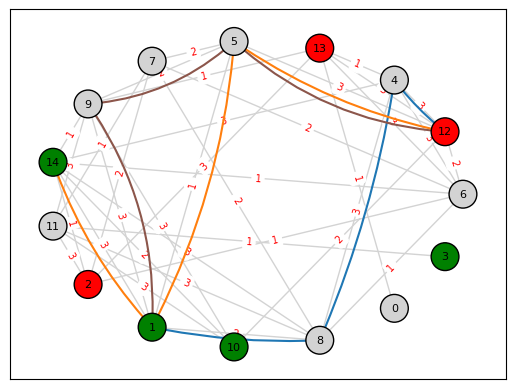

In [16]:
status = solver.Solve()
if status == pywraplp.Solver.OPTIMAL:
    print(f'Problem solved with a minimum of {round(solver.Objective().Value())} vehicles')
    print(' ')
    print('All supply points:')

    graph_edges = {(i,j) for (i,j),o in h.items() if i<j and o>0}
    G = nx.Graph(graph_edges)

    plot_graph(G,F,R)

    draw_info(G,h)

    for i in F:
        vehicle_paths = []
        for k in K:
            if(round(r[i,k].solution_value()) == 1):
                path = [i]
                current = i

                while current != sink:
                    for j in V:
                        if round(x[current,j,k].solution_value()) == 1:
                            path.append(j)
                            current = j
                            break
                
                vehicle_paths.append((path,k))

        print(f'-> Supply point {i}:')
        print(f'    - Vehicles used (total of {len(vehicle_paths)}/{v[i]}):')
        total_units = 0
        for (path,vehicle) in vehicle_paths:
            p1 = round(t[i,vehicle,0].solution_value())
            p2 = round(t[i,vehicle,1].solution_value())
            p3 = round(t[i,vehicle,2].solution_value())

            total_units += p1*1 + p2*2 + p3*5
            print(f'        - Vehicle {vehicle}')
            print(f'        - Total units: 1*{p1} + 2*{p2} + 5*{p3} = {p1+2*p2+5*p3}')
            print(f'        - Used packages:')
            print(f'            - Type {0} (1 unit): {p1}')
            print(f'            - Type {1} (2 unit): {p2}')
            print(f'            - Type {2} (5 unit): {p3}')     
            print(f'        - Path:', end=' ')
            print(' -> '.join(map(str,path)))
            print(' ')
            
            plot_path(G,path,vehicle)
        print(f'    - Used stock: {total_units}/{s[i]}')
else:
    print('No solution found')

## Modelação final

Podemos assim criar uma função chamada `solverVRP` que resolve o problema para os *inputs* $n,F,R,a$ e $sink$.

In [17]:
def solverVRP(n,F,R,a,sink,plot_weights=False):
    solver = pywraplp.Solver.CreateSolver('SCIP')

    h,v,s = generate_graph(n,F)

    V = range(n)
    K = range(a[0]+a[1]+a[2])

    # Variáveis de decisão
    x,t,r = {},{},{}
    for i in V:
        for j in V:
            for k in K:
                x[i,j,k] = solver.BoolVar('x[%i][%i][%i]' % (i,j,k))

        for j in K:
            r[i,j] = solver.BoolVar('r[%i][%i]' % (i,j))
            for k in range(3):
                t[i,j,k] = solver.IntVar(0.0,solver.infinity(),'t[%i][%i][%i]' % (i,j,k))

    # Restrição 1: A capacidade dos veículos é respeitada, isto é, o número de unidades que cada veículo transporta não pode ser superior a 10.
    for i in F:
        for j in K:
            solver.Add(t[i,j,0]*1 + t[i,j,1]*2 + t[i,j,2]*5 <= r[i,j]*10)

    # Restrição 2: Limite de unidades de cada ponto de fornecimento
    for i in F:
        solver.Add(sum(t[i,k,0]*1 + t[i,k,1]*2 + t[i,k,2]*5 for k in K) <= s[i])

    # Restrição 3: A soma de todos os pacotes em cada veículo deve ser igual aos pacotes presentes na encomenda
    for k in range(3):
        solver.Add(sum(t[i,j,k] for i in F for j in K) == a[k])

    # Restrição 4: Limite de veículos que cada ponto de fornecimento dispõe
    for i in F:
        solver.Add(sum(r[i,k] for k in K) <= v[i])

    # Restrição 5: A conservação do fluxo, ou seja, o número de veículos que entram num ponto é igual ao número de veículos que saem desse ponto.
    for k in K:
        for i in V:
            if i in F:
                solver.Add(sum(x[i,j,k] for j in V) - sum(x[j,i,k] for j in V) == r[i,k]) 
            elif i == sink:
                solver.Add(sum(x[i,j,k] for j in V) - sum(x[j,i,k] for j in V) == -r[i,k]) 
            else:
                solver.Add(sum(x[i,j,k] for j in V) - sum(x[j,i,k] for j in V) == 0) 
    
    # Restrição 6: Cada veículo pertence a um só ponto de fornecimento
    for j in K:
        solver.Add(sum(r[i,j] for i in F) <= 1)

    # Restrição 7: O grau de entrada e saída de cada ponto é no máximo 1, para evitar ciclos desnecessários.
    for k in K:
        for i in V:
            solver.Add(sum(x[i,j,k] for j in V) <= 1) 
            solver.Add(sum(x[j,i,k] for j in V) <= 1) 

    # Restrição 8: A capacidade das estradas é respeitada
    for i in V:
        for j in V:
            solver.Add(sum(x[i,j,k] for k in K) <= h[i,j])

    # Objetivo: Minimizar o número de veículos utilizados
    solver.Minimize(sum(r[i,k] for i in F for k in K))

    # Cálculo e apresentação da solução
    status = solver.Solve()
    if status == pywraplp.Solver.OPTIMAL:
        print(f'Problem solved with a minimum of {round(solver.Objective().Value())} vehicles')
        print(' ')
        print('All supply points:')

        graph_edges = {(i,j) for (i,j),o in h.items() if i<j and o>0}
        G = nx.Graph(graph_edges)

        plot_graph(G,F,R)

        if plot_weights:
            draw_info(G,h)

        for i in F:
            vehicle_paths = []
            for k in K:
                if(round(r[i,k].solution_value()) == 1):
                    path = [i]
                    current = i

                    while current != sink:
                        for j in V:
                            if round(x[current,j,k].solution_value()) == 1:
                                path.append(j)
                                current = j
                                break
                    
                    vehicle_paths.append((path,k))

            print(f'-> Supply point {i}:')
            print(f'    - Vehicles used (total of {len(vehicle_paths)}/{v[i]}):')
            total_units = 0
            for (path,vehicle) in vehicle_paths:
                p1 = round(t[i,vehicle,0].solution_value())
                p2 = round(t[i,vehicle,1].solution_value())
                p3 = round(t[i,vehicle,2].solution_value())

                total_units += p1*1 + p2*2 + p3*5
                print(f'        - Vehicle {vehicle}')
                print(f'        - Total units: 1*{p1} + 2*{p2} + 5*{p3} = {p1+2*p2+5*p3}')
                print(f'        - Used packages:')
                print(f'            - Type {0} (1 unit): {p1}')
                print(f'            - Type {1} (2 unit): {p2}')
                print(f'            - Type {2} (5 unit): {p3}')     
                print(f'        - Path:', end=' ')
                print(' -> '.join(map(str,path)))
                print(' ')
                
                plot_path(G,path,vehicle)
            print(f'    - Used stock: {total_units}/{s[i]}')
    else:
        print('No solution found')

## Testes

Problem solved with a minimum of 3 vehicles
 
All supply points:
-> Supply point 1:
    - Vehicles used (total of 0/19):
    - Used stock: 0/2
-> Supply point 2:
    - Vehicles used (total of 3/5):
        - Vehicle 0
        - Total units: 1*1 + 2*3 + 5*0 = 7
        - Used packages:
            - Type 0 (1 unit): 1
            - Type 1 (2 unit): 3
            - Type 2 (5 unit): 0
        - Path: 2 -> 7 -> 6
 
        - Vehicle 1
        - Total units: 1*0 + 2*0 + 5*2 = 10
        - Used packages:
            - Type 0 (1 unit): 0
            - Type 1 (2 unit): 0
            - Type 2 (5 unit): 2
        - Path: 2 -> 5 -> 1 -> 6
 
        - Vehicle 2
        - Total units: 1*0 + 2*0 + 5*1 = 5
        - Used packages:
            - Type 0 (1 unit): 0
            - Type 1 (2 unit): 0
            - Type 2 (5 unit): 1
        - Path: 2 -> 7 -> 3 -> 10 -> 9 -> 6
 
    - Used stock: 22/22
-> Supply point 4:
    - Vehicles used (total of 0/2):
    - Used stock: 0/44


/tmp/ipykernel_22214/160071682.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab20', 20)


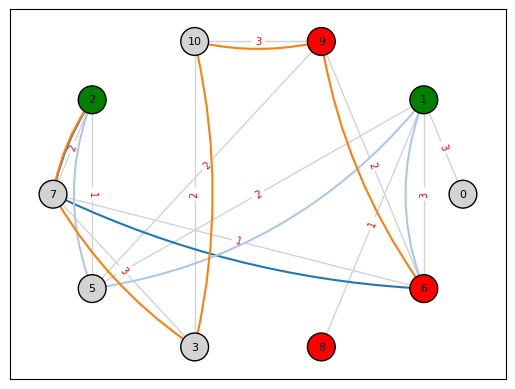

In [22]:
# Test 1:
solverVRP(11, {4,1,2}, {9,8,6}, {0:1,1:3,2:3}, 6, True)

Problem solved with a minimum of 5 vehicles
 
All supply points:
-> Supply point 1:
    - Vehicles used (total of 0/26):
    - Used stock: 0/8
-> Supply point 2:
    - Vehicles used (total of 3/18):
        - Vehicle 1
        - Total units: 1*0 + 2*0 + 5*2 = 10
        - Used packages:
            - Type 0 (1 unit): 0
            - Type 1 (2 unit): 0
            - Type 2 (5 unit): 2
        - Path: 2 -> 8
 
        - Vehicle 2
        - Total units: 1*0 + 2*0 + 5*2 = 10
        - Used packages:
            - Type 0 (1 unit): 0
            - Type 1 (2 unit): 0
            - Type 2 (5 unit): 2
        - Path: 2 -> 8
 
        - Vehicle 3
        - Total units: 1*0 + 2*0 + 5*2 = 10
        - Used packages:
            - Type 0 (1 unit): 0
            - Type 1 (2 unit): 0
            - Type 2 (5 unit): 2
        - Path: 2 -> 0 -> 8
 
    - Used stock: 30/30
-> Supply point 4:
    - Vehicles used (total of 2/20):
        - Vehicle 0
        - Total units: 1*1 + 2*4 + 5*0 = 9
        - Used

/tmp/ipykernel_22214/160071682.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab20', 20)


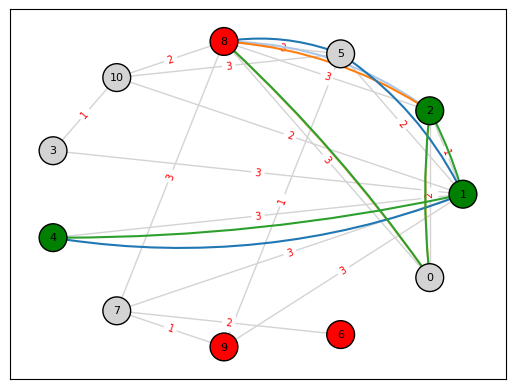

In [19]:
# Test 2:
solverVRP(11, {4,1,2}, {9,8,6}, {0:1,1:4,2:8}, 8, True)

Problem solved with a minimum of 12 vehicles
 
All supply points:
-> Supply point 1:
    - Vehicles used (total of 3/11):
        - Vehicle 20
        - Total units: 1*0 + 2*0 + 5*2 = 10
        - Used packages:
            - Type 0 (1 unit): 0
            - Type 1 (2 unit): 0
            - Type 2 (5 unit): 2
        - Path: 1 -> 23 -> 25 -> 2 -> 8
 
        - Vehicle 22
        - Total units: 1*0 + 2*0 + 5*2 = 10
        - Used packages:
            - Type 0 (1 unit): 0
            - Type 1 (2 unit): 0
            - Type 2 (5 unit): 2
        - Path: 1 -> 10 -> 8
 
        - Vehicle 23
        - Total units: 1*10 + 2*0 + 5*0 = 10
        - Used packages:
            - Type 0 (1 unit): 10
            - Type 1 (2 unit): 0
            - Type 2 (5 unit): 0
        - Path: 1 -> 11 -> 3 -> 25 -> 8
 
    - Used stock: 30/31
-> Supply point 2:
    - Vehicles used (total of 4/23):
        - Vehicle 2
        - Total units: 1*0 + 2*0 + 5*2 = 10
        - Used packages:
            - Type 0 (1 u

/tmp/ipykernel_22214/160071682.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab20', 20)


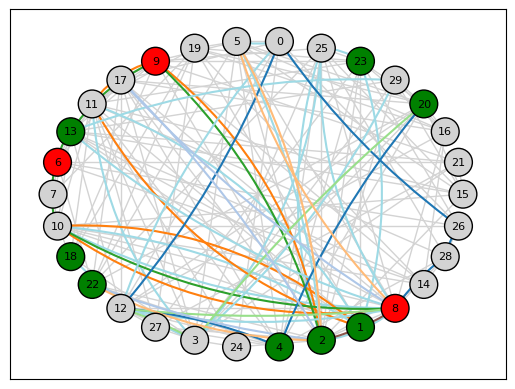

In [20]:
# Test 3:
solverVRP(30, {4,1,2,23,18,13,20,22}, {9,8,6}, {0:20,1:10,2:15}, 8)

Problem solved with a minimum of 13 vehicles
 
All supply points:
-> Supply point 1:
    - Vehicles used (total of 2/2):
        - Vehicle 13
        - Total units: 1*0 + 2*5 + 5*0 = 10
        - Used packages:
            - Type 0 (1 unit): 0
            - Type 1 (2 unit): 5
            - Type 2 (5 unit): 0
        - Path: 1 -> 27 -> 3 -> 14 -> 0 -> 2 -> 8
 
        - Vehicle 14
        - Total units: 1*0 + 2*5 + 5*0 = 10
        - Used packages:
            - Type 0 (1 unit): 0
            - Type 1 (2 unit): 5
            - Type 2 (5 unit): 0
        - Path: 1 -> 7 -> 36 -> 8
 
    - Used stock: 20/21
-> Supply point 34:
    - Vehicles used (total of 1/1):
        - Vehicle 4
        - Total units: 1*0 + 2*0 + 5*2 = 10
        - Used packages:
            - Type 0 (1 unit): 0
            - Type 1 (2 unit): 0
            - Type 2 (5 unit): 2
        - Path: 34 -> 0 -> 12 -> 1 -> 39 -> 38 -> 6 -> 22 -> 18 -> 33 -> 3 -> 11 -> 5 -> 8
 
    - Used stock: 10/33
-> Supply point 49:
    - Ve

/tmp/ipykernel_22214/160071682.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab20', 20)


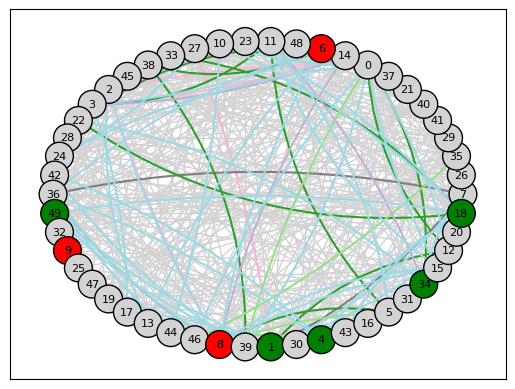

In [21]:
# Test 4:
solverVRP(50, {4,1,18,34,49}, {9,8,6}, {0:40,1:20,2:10}, 8)